# News Summarization with an Attention Mechanism
Author: Andrii Zapukhlyi

## Objective

## Solution

## Import libraries

In [38]:
import numpy as np
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random

## Dataset overview

In [39]:
df = datasets.load_dataset('cnn_dailymail', '3.0.0')

In [40]:
train = pd.DataFrame(df['train'])
val = pd.DataFrame(df['validation'])
test = pd.DataFrame(df['test'])

In [41]:
train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [42]:
print(len(train), len(val), len(test))

287113 13368 11490


In [43]:
train.sample(10)

,article,highlights,id
85565,"TEHRAN, Iran (CNN) -- Iran's controversial pre...",Iran President Mahmoud Ahmadinejad denies rift...,d9ef0c186b8b8fbf98e0989bbe815f38fb262969
58783,London (CNN) -- UK food safety officials have ...,NEW: Sweden's 3 largest retailers pull package...,7b337dd9d25cd267884449b9388dd6df26bb83ca
231760,Marouane Fellaini would agree that he became s...,Marouane Fellaini had to call on support of hi...,8bf3c6bd324c4dd4342e82e82d4cd5d5c8fdf9d7
220300,They have already made it on to the big screen...,Manchester United's Class of '92 now co-own Sa...,fac8aaa898e357ba08f0a08aa629ad484e0b9046
129445,"By . Jenny Hope . PUBLISHED: . 18:45 EST, 23 J...",Youngsters aged six to 11 will be able to bene...,8f4b4e51c7fd2db3d0160ea525e325db3755fe84
109311,By . Daily Mail Reporter . UPDATED: . 14:11 ES...,'The future is here' said Obama on visit to fi...,9bc79420157998bc326ef2816e738184f4b367ae
48462,"(EW.com) -- ""Holler If Ya Hear Me,"" a new musi...",A musical featuring the music of rapper Tupac ...,ecb7cfc266761cb75b3c3ad051e8115eb2f11a28
120414,By . Daily Mail Reporter . PUBLISHED: . 14:49 ...,Police officers found the body of Michael Phil...,7bfe177f6841300a39ea5a3c84c06f20d8ffcb77
264533,This is the astonishing moment a Polish man so...,Marcin Kowalczyk set the record during a compe...,a4e390fc5e4202b8f5f4f3b631addba82dc8d3a7
96385,By . Snejana Farberov . PUBLISHED: . 08:01 EST...,"Estrella Carrera, 26, married on Friday night ...",819475e0c70a3def643f04dce055cd936fcd3b96


In [44]:
train.describe()

,article,highlights,id
count,287113,287113,287113
unique,284005,282197,287113
top,"SHANGHAI, China (CNN) -- If it weren't for th...",This page includes the show Transcript and the...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
freq,3,83,1


In [45]:
def delete_wrong_scraped(set):
    wrong_scraped = ["This page includes the show Transcript", "The daily transcript is a written version", "Use the weekly Newsquiz to test your", "Use these questions to help students understan"]

    for elem in wrong_scraped:
        set = set[~set['highlights'].str.contains(elem, na=False, case=False)]

    return set

train = delete_wrong_scraped(train)
val = delete_wrong_scraped(val)
test = delete_wrong_scraped(test)

In [46]:
print(train.describe())
print(val.describe())
print(test.describe())

                                                  article  \
count                                              286631   
unique                                             283523   
top     (CNN) -- Dubai could lose its place on the Wom...   
freq                                                    3   

                                               highlights  \
count                                              286631   
unique                                             282146   
top     Rick Steves writes European travel guidebooks ...   
freq                                                    9   

                                              id  
count                                     286631  
unique                                    286631  
top     42c027e4ff9730fbb3de84c1af0d2c506e41c3e4  
freq                                           1  
                                                  article  \
count                                               13351   
unique     

In [47]:
print("Number of NA values in sets:")
print(train.isna().sum().sum())
print(val.isna().sum().sum())
print(test.isna().sum().sum())

print("Number of duplicates in sets:")
print(train.duplicated().sum())
print(val.duplicated().sum())
print(test.duplicated().sum())

Number of NA values in sets:
0
0
0
Number of duplicates in sets:
0
0
0


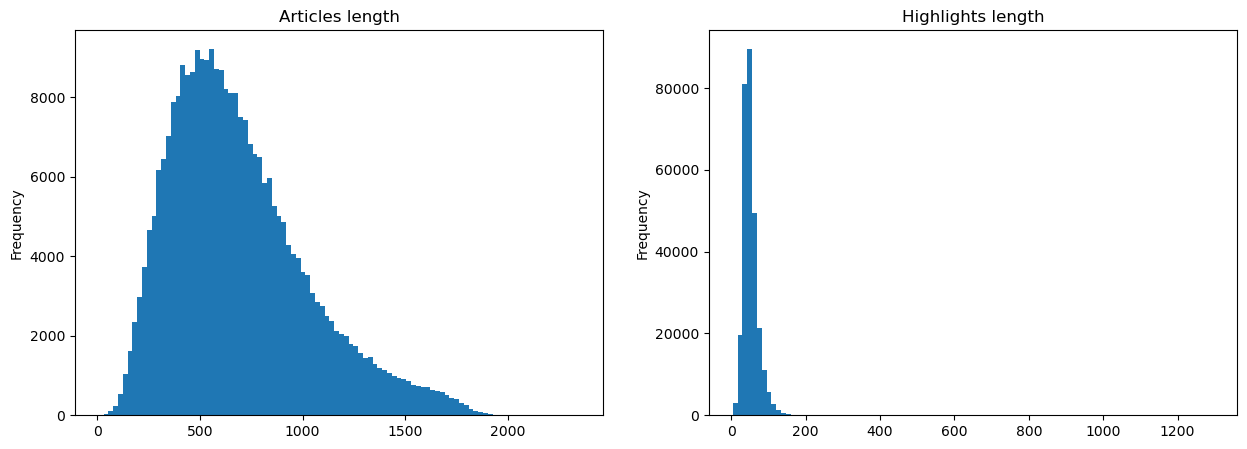

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

train["article"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100, ax = ax[0])
ax[0].set_title('Articles length')

train["highlights"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100)
ax[1].set_title('Highlights length')

plt.show()

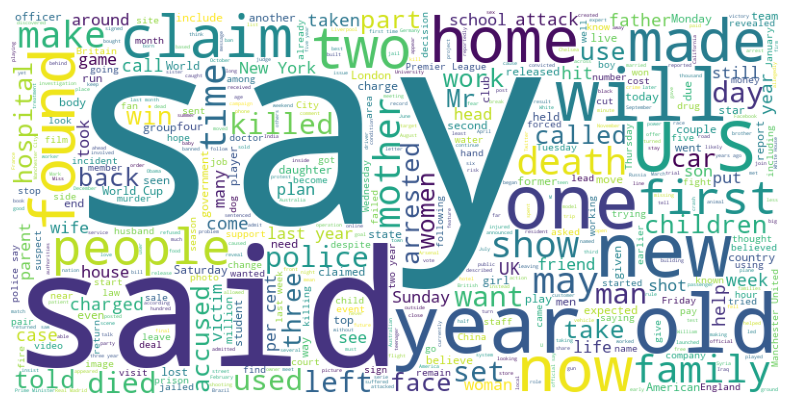

In [49]:
from wordcloud import WordCloud

text_data = " ".join(train['highlights'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=1000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

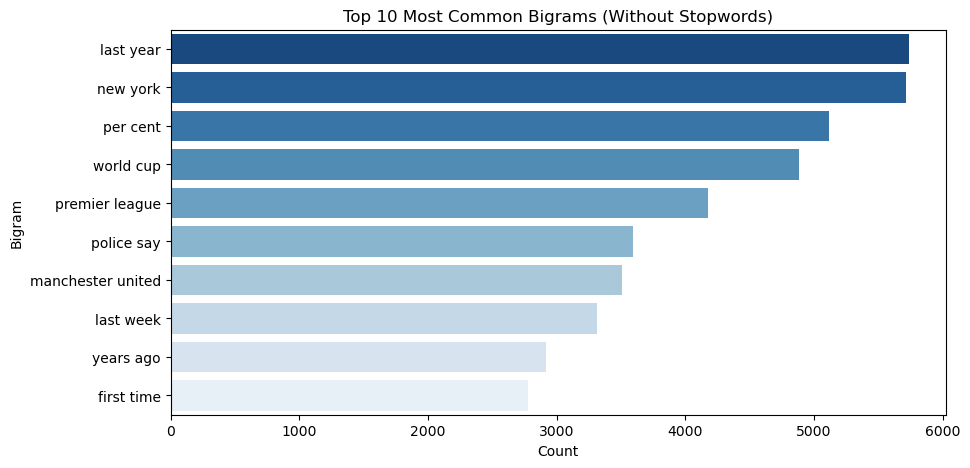

In [50]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import nltk

stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in train["highlights"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

## Data preprocessing

In [ ]:
import re 

def delete_metadata(text):
    if not isinstance(text, str):
        return text

    # Remove "By . Author Name ."
    text = re.sub(r"^By\s+.*?\.\s+", "", text)

    # Remove "PUBLISHED: ... | UPDATED: ..." timestamps
    text = re.sub(r'PUBLISHED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*\s*\|?\s*UPDATED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*', '', text)

    match = re.search(r"UPDATED: .*? \. (.*)", text)

    if match:
        text = match.group(1).strip()

    # Remove "Last updated at ..." timestamps
    text = re.sub(r'Last updated at \d{1,2}:\d{2} [APM]{2} on \d{1,2}(st|nd|rd|th)? \w+ \d{4} \.', '', text)

    # Remove source prefixes like "(CNN) --", "(BBC) --", "(NYT) --"
    text = re.sub(r'^.*?--\s*', '', text)

    # Remove "Follow @username . " or similar patterns at the start
    text = re.sub(r"^Follow\s+@@\S+\s+\.\s+", "", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

train["article"] = train["article"].apply(delete_metadata).reset_index(drop=True)
val["article"] = val["article"].apply(delete_metadata).reset_index(drop=True)
test["article"] = test["article"].apply(delete_metadata).reset_index(drop=True)

In [112]:
train.sample(10)

,article,highlights,id
13954,if and when it happens. Another source indicat...,Tim Allen is looking to stage a return to prim...,8822623203f2e477043a18c11c808f4510faf83f
190869,"The third, and final, supermoon of the summer ...",Last night marked the fourth supermoon of the ...,d4b3eaf4d8164378ad2f56e2d3b74a6c9d1514cf
83091,yet there is more of it than anything else in ...,Three U.S.-trained scientists won the Nobel pr...,7b97e14f8bdcee6499af95d61e07c8e496004b04
90191,Daily Mail Reporter . Heroin overdoses are tra...,"Danielle Blankenship, 21, of Boulder is charge...",ac58961a3681f4acc31e167855bdd3828e16d639
278234,A change to the recipe of Newcastle Brown Ale ...,Newcastle Brown Ale's distinctive hue comes fr...,da2c15ac0ce72f47cddd9ebbb2f448f6df23adcb
32495,aboard in carry-on luggage. Pistole said the m...,The TSA said it would allow small knives onto ...,de1bf0b6f82c3d09d1464480f4032154260af3e6
33019,"were found in her room in Istanbul, though her...",A feed of photos on Instagram marks Sierra's t...,6eaec304564776a976f445df117d65383f492106
110848,The survivor of a horrific military rape has b...,Kori Cioca served in the U.S. Coast Guard and ...,5737daac0afc4f73656168ebdc15c60f9f0bd2f8
17074,Some New York police officers still cannot com...,Radios so faulty some officers use cell phones...,4ecfacd288d90e2b5ecea3b3e269d21e16df0e75
148877,"City trader: Robin Clark, pictured, was shot i...","Robin Clark, 44 was shot in the thigh at Shenf...",9ad76b66421b830a7ba57a67dd3c7f2c06c508d9


In [114]:
def clean_text(text):
    if not isinstance(text, str):
        return text
    
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\n+', ' ', text)
    text = text.strip()
    return text

train["article"] = train["article"].apply(clean_text).reset_index(drop=True)
val["article"] = val["article"].apply(clean_text).reset_index(drop=True)
test["article"] = test["article"].apply(clean_text).reset_index(drop=True)

train["highlights"] = train["highlights"].apply(clean_text).reset_index(drop=True)
val["highlights"] = val["highlights"].apply(clean_text).reset_index(drop=True)
test["highlights"] = test["highlights"].apply(clean_text).reset_index(drop=True)